---
title: Fitting a Dynamic Model
type: submodule
---

# Fitting a Dynamic Model

## Introduction

This example takes us through the beginning of the triple pendulum example again.  

In [1]:
# -*- coding: utf-8 -*-

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

We need to import some additional libraries for optimization and interpolation

In [2]:
import logging
import pynamics.integration
import pynamics.system
import numpy.random
import scipy.interpolate
import scipy.optimize
import cma

The rest of this code proceeds as in the triple pendulum example...

In [3]:
system = System()
pynamics.set_system(__name__,system)

lA = Constant(1,'lA',system)
lB = Constant(1,'lB',system)
lC = Constant(1,'lC',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)

g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system)
k = Constant(1e1,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

tol = 1e-12

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

initialvalues = {}
initialvalues[qA]=-45*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=0*pi/180
initialvalues[qC_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')

system.set_newtonian(N)

A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)

pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x

pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x

wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)

IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)

system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*N.z,wAB)
system.add_spring_force1(k,(qC-preload3)*N.z,wBC)

system.addforcegravity(-g*N.y)

We're going to run this example without constraints

In [4]:
eq = []
# eq.append(pCtip.dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

Proceeding...

In [5]:
f,ma = system.getdynamics()

2020-12-18 11:00:32,404 - pynamics.system - INFO - getting dynamic equations


## Modifications

Now here's where the code diverges.  Instead of just integrating the system with the values specified when the constants were created, we're going to split our set of constants into ones we know from calculating them, measuring them, or specifying them, and the constants we _don't know_ because they are difficult to measure independently or only manifest in the full system.  In other words, we are separating our constants into ones we are supplying ourselves to the model, and the ones we are hoping to find using optimization

In this case, as an example, we specify that the damping ratio and joint stiffness are unknown:

In [6]:
unknown_constants = [b,k]

From the set of system constants already defined, we can say that all the other constants are "known"; we use the default values specified above for these

In [7]:
known_constants = list(set(system.constant_values.keys())-set(unknown_constants))
known_constants = dict([(key,system.constant_values[key]) for key in known_constants])

Also different from the original triple pendulum example: we supply the known constants earlier, when we generate our integration function.  This can help speed up integration by eliminating constants that do not change every time we integrate, making sympy's substitution process shorter.  Pynamics gives you the ability to specify constants when creating the state-space equations or during integration.  Note that we are only supplying the known constants at this point.

In [8]:
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True,constants = known_constants)

2020-12-18 11:00:32,827 - pynamics.system - INFO - solving a = f/m and creating function
2020-12-18 11:00:33,611 - pynamics.system - INFO - substituting constrained in Ma-f.
2020-12-18 11:00:33,842 - pynamics.system - INFO - done solving a = f/m and creating function
2020-12-18 11:00:33,842 - pynamics.system - INFO - calculating function for lambdas


Now we create a function to run the integration.  The input arguments (args) of this function are the unknown contants that we are trying to solve for.   We then create a dictionary (constants) that we feed into the integration step, so that each time we run this function, we can be generating the motion of a  system with different $b$ and $k$ values.

In [9]:
def run_sim(args):
    constants = dict([(key,value) for key,value in zip(unknown_constants,args)])
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':constants},))
    return states

Define the points that make up the motion-tracked points.  Note: your data should already be normalized for the proper scaling and orientation.

In [10]:
points = [pNA,pAB,pBC,pCtip]

## Synthesizing Data (optional)

Because I don't have a three-link pendulum on hand, I have to create some data to which the next part of my code can be fit.  The next steps create some synthetic, noisy data to demonstrate our model-fitting procedure with.  In normal circumstances, you would be supplying input data in the form of x-y point values extracted from motion data.  In this case, we first generate some data for a given model, add some noise, and then solve with a different initial guess for those same parameters.

When modifying this code for your use, this is where you would want to insert data from your own experiment

First, run the simulation at a selected set of values for b and k

In [11]:
input_data = run_sim([1.1e2,9e2])

2020-12-18 11:00:33,933 - pynamics.integration - INFO - beginning integration
2020-12-18 11:00:33,933 - pynamics.system - INFO - integration at time 0000.00
2020-12-18 11:00:34,403 - pynamics.system - INFO - integration at time 0000.47
2020-12-18 11:00:35,057 - pynamics.system - INFO - integration at time 0001.65
2020-12-18 11:00:35,772 - pynamics.system - INFO - integration at time 0006.07
2020-12-18 11:00:36,490 - pynamics.system - INFO - integration at time 0006.76
2020-12-18 11:00:37,207 - pynamics.system - INFO - integration at time 0007.14
2020-12-18 11:00:37,776 - pynamics.system - INFO - integration at time 0007.50
2020-12-18 11:00:38,292 - pynamics.system - INFO - integration at time 0007.88
2020-12-18 11:00:39,310 - pynamics.system - INFO - integration at time 0008.26
2020-12-18 11:00:40,350 - pynamics.system - INFO - integration at time 0008.63
2020-12-18 11:00:41,111 - pynamics.system - INFO - integration at time 0008.94
2020-12-18 11:00:41,838 - pynamics.system - INFO - in

Next, create an Output to compute the motion of our markers

In [12]:
points_output = PointsOutput(points,system)

Then compute the output points.  We can plot them to see what they should look like

2020-12-18 11:00:43,591 - pynamics.output - INFO - calculating outputs
2020-12-18 11:00:43,660 - pynamics.output - INFO - done calculating outputs


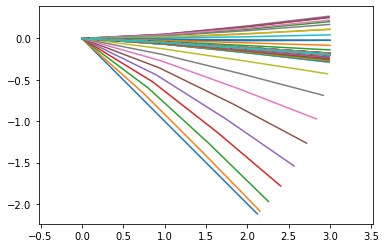

In [13]:
y = points_output.calc(input_data)
points_output.plot_time()
# points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

Now create some random noise the same shape as y and add the noise to y.  We're doing this so that our optimization process gets some data that looks like we might expect it to if it were to come from a real sensor.  The scaling of the error can be tuned, and will affect the model we obtain as well as the model's accuracy.  This is a problem when working with real data too.

In [14]:
r = numpy.random.randn(*(y.shape))*.01
y += y + r

Reshape the y vector so it is 2D, for saving to a csv file

In [15]:
y = y.reshape((len(t),-1))
numpy.savetxt("data.csv", y, delimiter=",")
# save the synthesized input data

## Loading Data

Now load the input data.

In [16]:
y = numpy.genfromtxt('data.csv', delimiter=',')

Because raw data may not correspond exactly to the simulated time series data, you will need to interpolate the data to fit the time series you are planning to run in your simulation.  Since you have predefined your time series, ```t```, you can precomute the interpolated input data, ```fyt```.

In [17]:
fy = scipy.interpolate.interp1d(t,y.T,fill_value='extrapolate')
fyt = fy(t).T

plot the input data.  You should see a small bit of noise in the system.

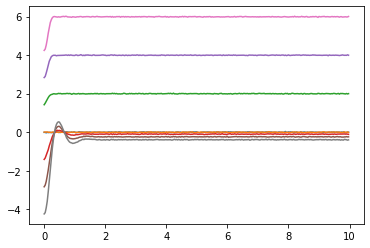

In [18]:
plt.figure()
plt.plot(t,fyt)

Now define a function that calculates the sum of squared error between your guessed system and your input data.  This function is in the form required to work with ```scipy.optimize.minimize()``` as well as the CMA package.

In [19]:
def calc_error(args):
    states_guess = run_sim(args)
    y_guess = points_output.calc(states_guess)
    y_guess = y_guess.reshape((300,-1))
    error = fyt - y_guess
    error **=2
    error = error.sum()
    return error    

stop logging integration INFO messages for simplicity's sake.

In [20]:
pynamics.system.logger.setLevel(logging.ERROR)

Create an initial guess for $b$ and $k$

In [21]:
k_guess = [1e2,1e3]

We can try to optimize using a number of methods.  The [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) package's [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function permits one to try a variety of methods, as well as to include constraints or bounds as well as a number of other arguments.

In this case, we select either CMA or a scipy method based on the string in the ```method``` variable.

**Note:** The optimization process can take a long time.  Change the method to 'CMA' or 'BGFS' to actually run it.

In [22]:
method = None
#method = 'CMA'
#method = 'BFGS'

if method is None:
    result = k_guess
elif method == 'CMA':
    es = cma.CMAEvolutionStrategy(k_guess, 0.5)
    es.logger.disp_header()
    while not es.stop():
          X = es.ask()
          es.tell(X, [calc_error(x) for x in X])
          es.logger.add()
          es.logger.disp([-1])
    result = es.best.x
else:
    sol = scipy.optimize.minimize(calc_error,k_guess,method = method)
    print(sol.fun)
    result = sol.x


Now, calculate the error of the best fit model against the input data.

In [23]:
calc_error(result)

2020-12-18 11:00:45,244 - pynamics.integration - INFO - beginning integration
2020-12-18 11:00:53,745 - pynamics.integration - INFO - finished integration
2020-12-18 11:00:53,745 - pynamics.output - INFO - calculating outputs
2020-12-18 11:00:53,826 - pynamics.output - INFO - done calculating outputs


4201.982424496521

Compare that to the error of the actual model against the noisy version of itself:

In [24]:
calc_error(k_guess)

2020-12-18 11:00:53,856 - pynamics.integration - INFO - beginning integration
2020-12-18 11:01:01,706 - pynamics.integration - INFO - finished integration
2020-12-18 11:01:01,708 - pynamics.output - INFO - calculating outputs
2020-12-18 11:01:01,756 - pynamics.output - INFO - done calculating outputs


4201.982424496521

Now plot the resulting motion and render a movie of the best-fit model.

2020-12-18 11:01:01,766 - pynamics.integration - INFO - beginning integration
2020-12-18 11:01:10,278 - pynamics.integration - INFO - finished integration
2020-12-18 11:01:10,278 - pynamics.output - INFO - calculating outputs
2020-12-18 11:01:10,328 - pynamics.output - INFO - done calculating outputs


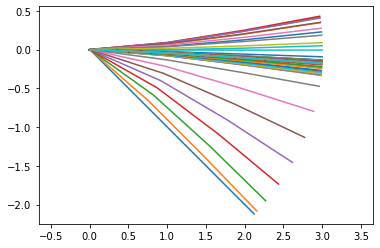

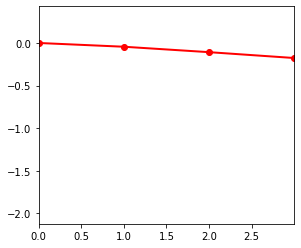

In [25]:
input_data_all2 = run_sim(result)
y2 = points_output.calc(input_data_all2)
points_output.plot_time()
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

Required to animate in jupyter notebook:

In [26]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())